In [ ]:
# Need to restart after:
!pip install convokit[llm]
!pip install convokit

In [ ]:
os.chdir('/content/temporal_belief_analysis/notebooks')
print("Changed working directory to:", os.getcwd())

# Absolute path to src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [13]:
import time
import sys
import os
!pip install gdown
import zipfile
import nltk
from nltk.corpus import stopwords
from convokit import Corpus, download
import convokit
from temporal_belief.core.timeline_building import TimelineBuilder
# from temporal_belief.core.change_detection import ChangeDetector
# from temporal_belief.core.window_extraction import WindowExtractor
# from temporal_belief.core.op_path_pairing import OpPathPairer
# from temporal_belief.data.preprocessors import ChangeDetectorPreprocessor
# from temporal_belief.data.preprocessors import PairPreprocessor
# from temporal_belief.core.interplay import Interplay
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Download and unzip with python (Dataloading):
# !gdown "https://drive.google.com/file/d/1N0U_jUJlOYjdaju2FaU8p87uB22YBxJ0/view?usp=sharing" -O "/content/temporal_belief_analysis/pd_corpus_with_stances100000_chronological.zip" --fuzzy
# !gdown "https://drive.google.com/file/d/1DLFY6JLMZqNjwvNRZmhlV4-rnoQP_eyH/view?usp=sharing" -O "/content/temporal_belief_analysis/merged_corpus_checkpoint_5.zip" --fuzzy
# !gdown "https://drive.google.com/file/d/1nWaj5N8nsG7u5homv_kAh4CLPDv01M_Z/view?usp=sharing" -O "/content/temporal_belief_analysis/pd_corpus_with_topics.zip" --fuzzy
!gdown "https://drive.google.com/file/d/15NMRXEkGRoGjK6TXFBHIMOPjkTyZ0keP/view?usp=sharing" -O "/content/temporal_belief_analysis/pd_corpus_with_stances200000_llm.zip" --fuzzy

# zipfile.ZipFile("/content/temporal_belief_analysis/pd_corpus_with_stances100000_chronological.zip").extractall("/content/temporal_belief_analysis")
# zipfile.ZipFile("/content/temporal_belief_analysis/merged_corpus_checkpoint_5.zip").extractall("/content/temporal_belief_analysis")
# zipfile.ZipFile("/content/temporal_belief_analysis/pd_corpus_with_topics.zip").extractall("/content/temporal_belief_analysis")
zipfile.ZipFile("/content/temporal_belief_analysis/pd_corpus_with_stances200000_llm.zip").extractall("/content/temporal_belief_analysis")

Downloading...
From (original): https://drive.google.com/uc?id=15NMRXEkGRoGjK6TXFBHIMOPjkTyZ0keP
From (redirected): https://drive.google.com/uc?id=15NMRXEkGRoGjK6TXFBHIMOPjkTyZ0keP&confirm=t&uuid=11d14a0f-728a-4003-8253-65737de8d389
To: /content/temporal_belief_analysis/pd_corpus_with_stances200000_llm.zip
100% 834M/834M [00:06<00:00, 128MB/s]


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [9]:
corpus = Corpus(filename="/content/temporal_belief_analysis/pd_corpus_with_stances200000_chronological_second_attempt")

In [44]:
from typing import Dict, Any
from collections import defaultdict
import logging

MERGED_TOPIC = {
    # Economy
    'economic policy': 'Economy & Tax',
    'taxation and government spending': 'Economy & Tax',

    # Healthcare
    'healthcare policy': 'Healthcare',

    # Civil rights / justice / education / voting
    'civil rights and social issues': 'Civil Rights, Justice & Education',
    'criminal justice and policing': 'Civil Rights, Justice & Education',
    'voting rights and elections': 'Civil Rights, Justice & Education',
    'education policy': 'Civil Rights, Justice & Education',

    # Hot-button singles
    'gun rights and control': 'Guns',
    'abortion and reproductive rights': 'Abortion',
    'immigration policy': 'Immigration',
    'climate change and energy policy': 'Climate & Energy',

    # Foreign / defense
    'foreign policy and defense': 'Foreign & Defense',

    # Meta / process / actors
    'political figures and campaigns': 'Process & Actors (Meta)',
    'congressional politics': 'Process & Actors (Meta)',
    'electoral politics': 'Process & Actors (Meta)',
    'political parties and ideology': 'Process & Actors (Meta)',
    'media and political commentary': 'Process & Actors (Meta)',
}


class TimelineBuilder:
    """Simple timeline builder for user belief tracking.

    Builds structure: {user_id: {topic: {utterance_id: stance}}}
    """

    def __init__(self, corpus, min_posts_per_topic: int = 0, min_topics_per_user: int = 0):
        self.corpus = corpus
        self.min_posts_per_topic = min_posts_per_topic
        self.min_topics_per_user = min_topics_per_user
        self.logger = logging.getLogger(__name__)

    def build_timelines(self, include_all=True) -> Dict[str, Dict[str, Dict[str, str]]]:
        """Build user timelines from corpus with stance metadata.

        Returns:
            {user_id: {topic: {utterance_id: stance}}}
        """
        # Group by user and topic
        user_topic_posts = defaultdict(lambda: defaultdict(list))

        for utterance in self.corpus.iter_utterances():
            # Skip if no stance metadata on utterance
            if include_all == False:
                if not utterance.meta or 'detected_stance' not in utterance.meta:
                    continue

            # Get topic from conversation metadata
            conversation = utterance.get_conversation()
            if not conversation or not conversation.meta or 'detected_topic' not in conversation.meta:
                continue

            if not utterance.timestamp:
                continue

            user_id = utterance.speaker.id
            old_topic = conversation.meta['detected_topic']
            topic = MERGED_TOPIC.get(old_topic, old_topic)
            stance = utterance.meta.get('detected_stance', 'Unknown')

            user_topic_posts[user_id][topic].append({
                'utterance_id': utterance.id,
                'timestamp': utterance.timestamp,
                'stance': stance
            })

        # Filter and sort
        timelines = {}
        for user_id, topic_posts in user_topic_posts.items():
            user_timeline = {}

            for topic, posts in topic_posts.items():
                if len(posts) >= self.min_posts_per_topic:
                    # Sort chronologically
                    posts.sort(key=lambda x: x['timestamp'])

                    # Create topic timeline
                    topic_timeline = {}
                    for post in posts:
                        topic_timeline[post['utterance_id']] = post['stance']

                    user_timeline[topic] = topic_timeline

            # Only include users with enough topics
            if len(user_timeline) >= self.min_topics_per_user:
                timelines[user_id] = user_timeline

        self.logger.info(f"Built timelines for {len(timelines)} users")
        return timelines

===============================================================================

===============================================================================

In [70]:
import numpy as np
import torch

def moving_avg_1d(x, w=3):
    if w <= 1: return x
    pad = (w - 1) // 2
    xpad = np.pad(x, (pad, pad), mode='edge')
    kernel = np.ones(w, dtype=np.float32) / w
    return np.convolve(xpad, kernel, mode='valid')

def decode_change_points(probs_1d, mask_1d, thresh=0.6, smooth_w=3, min_gap=3):
    """
    probs_1d: (T,) numpy array in [0,1]
    mask_1d:  (T,) numpy array in {0,1}
    Returns: list of timestep indices predicted as change points.
    """
    p = probs_1d.copy()
    # honor mask (don’t trigger on masked timesteps)
    p[mask_1d < 0.5] = 0.0
    # smooth (optional)
    if smooth_w and smooth_w > 1:
        p = moving_avg_1d(p, w=smooth_w)

    # threshold
    cand = np.where(p >= thresh)[0].tolist()

    # minimum spacing
    picked = []
    last = -10**9
    for t in cand:
        if t - last >= min_gap:
            picked.append(t)
            last = t
    return picked

In [71]:
def match_with_tolerance(pred, truth, tol=2):
    """Greedy match: a pred counts correct if within ±tol of an unmatched truth."""
    pred = sorted(pred)
    truth = sorted(truth)
    used = set()
    tp = 0
    for t in pred:
        # find nearest unmatched truth within tolerance
        best_j, best_dist = None, tol+1
        for j, g in enumerate(truth):
            if j in used:
                continue
            d = abs(t - g)
            if d <= tol and d < best_dist:
                best_j, best_dist = j, d
        if best_j is not None:
            used.add(best_j)
            tp += 1
    fp = len(pred) - tp
    fn = len(truth) - tp
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2*precision*recall / (precision+recall+1e-9)
    return precision, recall, f1

# Example on that single sequence b
prec, rec, f1 = match_with_tolerance(pred, truth, tol=2)
print(f"Seq b metrics (±2): P={prec:.3f} R={rec:.3f} F1={f1:.3f}")

NameError: name 'pred' is not defined

In [51]:
timeline_builder = TimelineBuilder(corpus)
timelines = timeline_builder.build_timelines(include_all=False)

In [52]:
print(len(timelines))

586


In [72]:
# --- Dataset producing (X, y, mask) per sequence ---
STANCE2ID = {"neutral": 0, "left-leaning": 1, "right-leaning": 2}
NEUTRAL_ID = 0

def to_fixed_len(ids, T=128):
    ids = ids[-T:]
    if len(ids) < T:
        ids = [NEUTRAL_ID]*(T-len(ids)) + ids
    return np.array(ids, dtype=np.int64)

class SeqTokDataset(Dataset):
    def __init__(self, timelines, T=128):
        X_list, Y_list, M_list = [], [], []
        for _, topics in timelines.items():
            for _, stance_dict in topics.items():
                ids = [STANCE2ID[s] for s in stance_dict.values() if s in STANCE2ID]
                if len(ids) < 2:
                    continue
                ids = to_fixed_len(ids, T)     # (T,)

                y = np.zeros(T, dtype=np.float32)
                m = np.zeros(T, dtype=np.float32)
                for t in range(1, T):
                    prev_id, cur_id = ids[t-1], ids[t]
                    y[t] = 1.0 if cur_id != prev_id else 0.0
                    # Mask out transitions touching neutral (training focus on left<->right)
                    m[t] = 0.0 if (prev_id == NEUTRAL_ID or cur_id == NEUTRAL_ID) else 1.0
                # y[0]=0, m[0]=0 by definition

                X_list.append(ids); Y_list.append(y); M_list.append(m)

        self.X = torch.tensor(np.stack(X_list), dtype=torch.long)      # (N, T)
        self.y = torch.tensor(np.stack(Y_list), dtype=torch.float32)   # (N, T)
        self.m = torch.tensor(np.stack(M_list), dtype=torch.float32)   # (N, T)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):  return self.X[i], self.y[i], self.m[i]

In [73]:
# --- 2. Define LSTM model ---
import torch
import torch.nn as nn

class LSTMChangeTagger(nn.Module):
    def __init__(self, vocab_size=3, emb_dim=16, hidden_dim=64, num_layers=1):
        super().__init__()
        self.emb  = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)  # one logit per timestep

    def forward(self, x_ids):                # (B, T)
        x = self.emb(x_ids)                  # (B, T, E)
        out, _ = self.lstm(x)                # (B, T, H)
        logits = self.fc(out).squeeze(-1)    # (B, T)
        return logits

In [74]:
# --- 3. Training setup ---
model = LSTMChangeTagger(vocab_size=3, emb_dim=16, hidden_dim=64, num_layers=1)
# Optional (see note 3 below): handle imbalance so positives matter more
pos_weight = torch.tensor([4.0])  # tweak later; 3–10 is common
bce = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)
# criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

In [75]:
# --- 4. Training loop ---
# timelines = { user: { topic: OrderedDict(utt_id->"neutral"/"left"/"right"), ... }, ... }

ds = SeqTokDataset(timelines, T=128)
loader = DataLoader(ds, batch_size=32, shuffle=True)

epochs = 8
epoch_losses = []
for epoch in range(epochs):
    model.train()
    running = 0.0
    steps = 0
    for xb, yb, mb in loader:             # xb:(B,T), yb:(B,T), mb:(B,T)
        opt.zero_grad()
        logits = model(xb)                 # (B,T)
        loss_mat = bce(logits, yb)         # (B,T)
        loss = (loss_mat * mb).sum() / (mb.sum().clamp_min(1.0))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        running += float(loss.item())      # <- update running
        steps += 1
    avg = running / max(steps, 1)
    epoch_losses.append(avg)
    print(f"epoch {epoch+1}/{epochs}  loss {avg:.4f}")

epoch 1/8  loss 1.1712
epoch 2/8  loss 1.0917


KeyboardInterrupt: 

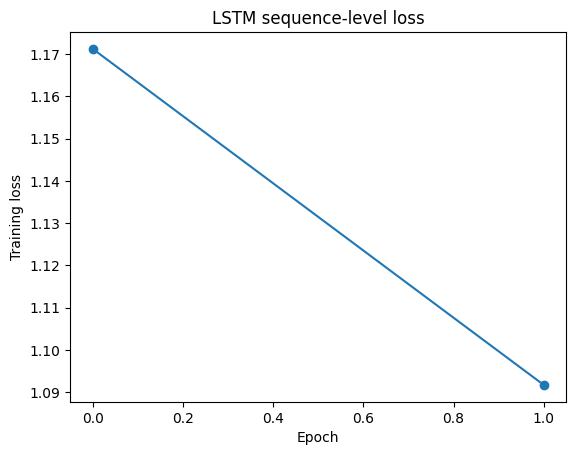

In [76]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('LSTM sequence-level loss')
plt.show()

In [77]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    xb, yb = next(iter(loader))        # one batch
    logits = model(xb)                 # (B,2)
    probs  = F.softmax(logits, dim=-1) # (B,2)
    preds  = probs.argmax(dim=-1)      # (B,)

    print("Logits[0]:", logits[0].tolist())
    print("Probs[0]: ", probs[0].tolist())
    print("Pred[0] vs gold:", int(preds[0]), int(yb[0]))

ValueError: too many values to unpack (expected 2)

In [69]:
model.eval()
with torch.no_grad():
    xb, yb, mb = next(iter(loader))
    logits = model(xb)                     # (B,T)
    probs  = torch.sigmoid(logits)         # (B,T)

b = 0
p = probs[b].cpu().numpy()
m = mb[b].cpu().numpy()
pred = decode_change_points(p, m, thresh=0.6, smooth_w=3, min_gap=3)
truth = np.where((yb[b].cpu().numpy() > 0.5) & (m > 0.5))[0].tolist()

print("Predicted change indices:", pred)
print("True change indices     :", truth[:20], "...")  # sample
print("First 30 probs:", np.round(p[:30], 2).tolist())

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# RUN AFTER TRAINING. THIS GIVES YOU PRED:

# 1) Grab one batch and get per-timestep probabilities
model.eval()
with torch.no_grad():
    xb, yb, mb = next(iter(loader))      # xb:(B,T), yb:(B,T), mb:(B,T)
    logits = model(xb)                   # (B,T)
    probs  = torch.sigmoid(logits)       # (B,T)

# 2) Pick a sequence in the batch, decode to change indices
b = 0
p = probs[b].cpu().numpy()
m = mb[b].cpu().numpy()
pred  = decode_change_points(p, m, thresh=0.6, smooth_w=3, min_gap=3)

# 3) Get the ground truth change indices (masked)
truth = np.where((yb[b].cpu().numpy() > 0.5) & (m > 0.5))[0].tolist()

# 4) Now evaluate with tolerance
prec, rec, f1 = match_with_tolerance(pred, truth, tol=2)
print("Predicted change indices:", pred)
print("True change indices     :", truth)
print(f"(±2)  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

If you want to evaluate over all sequences, loop over the DataLoader, collect pred/truth per sequence, and average metrics.^^^^ (WHAT DOES THAT MEAN?)